In [1]:
pip install contractions

In [2]:
!pip install pytorch_pretrained_bert

In [3]:
import contractions
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string 
import tensorflow as tf
import tensorflow_hub as hub

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, hamming_loss, precision_score, roc_auc_score, roc_curve, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from string import digits
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, LeakyReLU, Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, FalseNegatives, FalsePositives
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from pytorch_pretrained_bert import BertTokenizer
from tensorflow.keras.models import Model 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing

In [4]:
# Import data
train = pd.read_excel('Trainset.xlsx')
test = pd.read_excel('Testset.xlsx')

# Eliminate the NAs
train = train.fillna('')
test = test.fillna('')

# Remove the rows without Opinion Category values
train = train[train.OpinionCategory != ''] 
test = test[test.OpinionCategory != ''] 

# Sort the data
train = train.sort_values('ID_and_Review').reset_index(drop=True)
test = test.sort_values('ID_and_Review').reset_index(drop=True)

In [5]:
train.head()

,ID_number,Review_ID,ID_and_Review,OutOfScope,Sentence_ID,OpinionCategory,OpinionFrom,Polarity,AspectTerm,OpinionTo,Text
0,1004293,1,1004293:0,,1,RESTAURANT#GENERAL,51,negative,place,56,Judging from previous posts this used to be a ...
1,1004293,1,1004293:1,,2,SERVICE#GENERAL,75,negative,staff,80,"We, there were four of us, arrived at noon - t..."
2,1004293,1,1004293:2,,3,SERVICE#GENERAL,0,negative,,0,"They never brought us complimentary noodles, i..."
3,1004293,1,1004293:3,,4,FOOD#QUALITY,4,negative,food,8,The food was lousy - too sweet or too salty an...
4,1004293,1,1004293:3,,4,FOOD#STYLE_OPTIONS,52,negative,portions,60,The food was lousy - too sweet or too salty an...


In [6]:
train.Polarity.value_counts(), test.Polarity.value_counts()

(positive    1657
 negative     749
 neutral      101
 Name: Polarity, dtype: int64, positive    611
 negative    204
 neutral      44
 Name: Polarity, dtype: int64)

Train data consists of 11 variables. The four of them indicate the ID numbers of the sentences, the reviewer, the review and the combination of them. OutofScope variable loses its function when I eliminated the null OpinionCategory values. The Opinion Category shows the aspect which the review refers to. The Opinion Category consists of 12 classes and each class has an entity and a corresponding attribute, in other words, E#A pairs. 

In this notebook, I will deal only with the Polarity and the corresponding reviews under the Text column.

## Multilabeling

In [7]:
# First, one-hot encode each sentence (duplicate ones as well)
train.Polarity = train.Polarity.astype('category')
one_hot = to_categorical(train.Polarity.cat.codes)
one_hot = pd.DataFrame(one_hot)

test.Polarity = test.Polarity.astype('category')
one_hot_test = to_categorical(test.Polarity.cat.codes)
one_hot_test = pd.DataFrame(one_hot_test)

one_hot.shape, one_hot_test.shape # There are 12 opinion category classes.

((2507, 3), (859, 3))

In [8]:
# Subtract the necessary columns for the analysis
useful_train = train[['Sentence_ID','Polarity','Text']]
useful_test = test[['Sentence_ID','Polarity','Text']]

# Concatenate the train data and the one-hot-encoding of the opinion category classes.
data_train = pd.concat([useful_train, one_hot], axis=1)
data_test = pd.concat([useful_test, one_hot_test], axis=1)

# Since the reviewer may have mentioned more than one opinion in a sentence, 
# Sum up the one-hot-encoded classes of each sentence.
multi_label = data_train.groupby('Sentence_ID').sum().reset_index(drop=True)
multi_label_test = data_test.groupby('Sentence_ID').sum().reset_index(drop=True)

# In each sentence, an opinion category may be refered more than one.
# Because of that, there were values besides 0 and 1, after the summation.
# Since being refered is important rather than how many times, the values such as 2 or 3 are reverted to one.
multi_label = np.array(multi_label.astype(bool).astype(int))
multi_label_test = np.array(multi_label_test.astype(bool).astype(int))

# After the multi-labeling of the sentences, remove the duplicates.
train_Text = data_train.drop_duplicates(subset=['Sentence_ID'], keep='last').Text
test_Text = data_test.drop_duplicates(subset=['Sentence_ID'], keep='last').Text

multi_label, multi_label.shape, multi_label_test, multi_label_test.shape

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]), (1708, 3), array([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        ...,
        [0, 0, 1],
        [1, 0, 1],
        [0, 0, 1]]), (587, 3))

## Undersampling & Oversampling

In [9]:
df = pd.merge(pd.DataFrame(train_Text).reset_index(drop=True), pd.DataFrame(multi_label), left_index=True, right_index=True)

In [10]:
imbalance_list =[]
for i in range(3):
  imbalance_list.append(len(df[df[i]== 1]))
imbalance_list

[592, 94, 1166]

In [11]:
df

,Text,0,1,2
0,Judging from previous posts this used to be a ...,1,0,0
1,"We, there were four of us, arrived at noon - t...",1,0,0
2,"They never brought us complimentary noodles, i...",1,0,0
3,The food was lousy - too sweet or too salty an...,1,0,0
4,"After all that, they complained to me about th...",1,0,0
...,...,...,...,...
1703,The service was extremely fast and attentive(t...,1,0,0
1704,The food was ok and fair nothing to go crazy.,1,0,0
1705,Over all the looks of the place exceeds the ac...,1,0,0
1706,So what you really end up paying for is the re...,1,0,0


In [12]:
x = df[df[0] == 1] # negative
y = df[df[1] == 1] # neutral
z = df[df[2] == 1] # positive

#x = x.append([x]*2,ignore_index=True)
y = y.append([y]*5,ignore_index=True)

train_df = pd.concat([df, x, y]).reset_index(drop=True)
train_df

,Text,0,1,2
0,Judging from previous posts this used to be a ...,1,0,0
1,"We, there were four of us, arrived at noon - t...",1,0,0
2,"They never brought us complimentary noodles, i...",1,0,0
3,The food was lousy - too sweet or too salty an...,1,0,0
4,"After all that, they complained to me about th...",1,0,0
...,...,...,...,...
2859,There is something about their atmosphere that...,0,1,0
2860,Not cheap but very yummy.,1,1,0
2861,Just go to Yamato and order the Red Dragon Roll.,0,1,1
2862,Once you try it for a special occasion beware....,0,1,1


In [13]:
imbalance_list =[]
for i in range(3):
  imbalance_list.append(len(train_df[train_df[i]== 1]))
imbalance_list

[1292, 676, 1418]

In [14]:
multi_label = np.array(train_df.iloc[:, 1:13])
multi_label, multi_label.shape

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 0]]), (2864, 3))

## Train & Test Data Cleaning

In [16]:
# Reset the indexes to remove confusion in next steps
train_Text = train_Text.astype('str').reset_index(drop = True)
test_Text = test_Text.astype('str').reset_index(drop = True)
train_Text

0       Judging from previous posts this used to be a ...
1       We, there were four of us, arrived at noon - t...
2       They never brought us complimentary noodles, i...
3       The food was lousy - too sweet or too salty an...
4       After all that, they complained to me about th...
                              ...                        
1703    The service was extremely fast and attentive(t...
1704        The food was ok and fair nothing to go crazy.
1705    Over all the looks of the place exceeds the ac...
1706    So what you really end up paying for is the re...
1707    Will prob. not return but it is a great dinnin...
Name: Text, Length: 1708, dtype: object

In [17]:
def cleanText(text):
    text = contractions.fix(text) # fix the contractions (such as I've = I have)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # remove urls
    text = ''.join([i for i in text if not i.isdigit()]) # remove numbers
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text) # remove punctuations
    text = text.lower() # make lower case
    return text

In [18]:
train_Text = train_df.Text.astype(str).map(lambda x: cleanText(x))
test_Text = test_Text.astype(str).map(lambda x: cleanText(x))
train_Text

0       judging from previous posts this used to be a ...
1       we there were four of us arrived at noon - the...
2       they never brought us complimentary noodles ig...
3       the food was lousy - too sweet or too salty an...
4       after all that they complained to me about the...
                              ...                        
2859    there is something about their atmosphere that...
2860                             not cheap but very yummy
2861      just go to yamato and order the red dragon roll
2862    once you try it for a special occasion beware ...
2863    the atmosphere was pretty nice but had a bit l...
Name: Text, Length: 2864, dtype: object

## Data Processing for Neural Network Models

### Tokenization 

In [ ]:
# Tokenization of texts 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_Text)
text_tokens = tokenizer.texts_to_sequences(train_Text)
text_tokens_test = tokenizer.texts_to_sequences(test_Text)
text_tokens[0]

[1270, 53, 482, 1271, 17, 833, 8, 31, 4, 19, 20, 12, 7, 109, 749]

### Padding

In [ ]:
# Check the longest text & aspect term for padding 
longestText = max([len(s.split()) for s in train_Text])
longestText_test = max([len(s.split()) for s in test_Text])
max_text = max(longestText, longestText_test)
longestText, longestText_test

(57, 51)

In [ ]:
X_train = pad_sequences(text_tokens,max_text, padding='post')
X_test = pad_sequences(text_tokens_test,max_text, padding='post')

GloVe Embedding

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index
len(word_index)

3038

In [ ]:
emb = 100
embedding_matrix = np.zeros((len(word_index)+1, emb))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector

In [ ]:
X_train.shape, X_test.shape, multi_label.shape, multi_label_test.shape, embedding_matrix.shape

((2864, 57), (587, 57), (2864, 3), (587, 3), (3039, 100))

# Basic Machine Learning Algorithms

In [ ]:
# Subtract the necessary columns for the analysis
useful_train = train[['Sentence_ID','Polarity','Text']]
useful_test = test[['Sentence_ID','Polarity','Text']]

In [ ]:
# To elobarate the results of the models, it is important to know the number of comments under each category.
# This also shows if the data is imbalanced or not.
counts = []
categories = list(sorted(useful_train.Polarity.values.unique()))
for i in categories:
    counts.append((i, len(useful_train[useful_train.Polarity == i])))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,negative,749
1,neutral,101
2,positive,1657


## Naive Bayes

In [ ]:
stop_words = set(stopwords.words('english'))
# Build the pipeline
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)), # feature extractor
                ('clf', OneVsRestClassifier( # necessary for multilabel classification
                    MultinomialNB(  
                    fit_prior=True, class_prior=None))),
            ])
# Fit the model in training data & get predictions
bayes_pred = []
for category, i in zip(categories, range(3)):
    NB_pipeline.fit(train_Text, multi_label[:,i])
    prediction = NB_pipeline.predict(test_Text)
    bayes_pred.append(prediction)

df_bayes_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_bayes_pred['{}'.format(category)] = bayes_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_bayes_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_bayes_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_bayes_pred), 3)))
# Classification Report
pred_bools = (np.array(df_bayes_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
accuracy = accuracy_score(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)
print(accuracy)

Test Precision: 0.58
Test Recall: 0.5
Test F1 Score: 0.532
Test Average Precision Score: 0
Subset accuracy: 0.404
Hamming loss: 0.316
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.35      0.31       165
           1       0.14      0.03      0.04        40
           2       0.74      0.60      0.66       425

   micro avg       0.57      0.50      0.53       630
   macro avg       0.39      0.33      0.34       630
weighted avg       0.58      0.50      0.53       630
 samples avg       0.49      0.51      0.49       630

0.403747870528109


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
svc_pred = []
for category, i in zip(categories, range(12)):
    SVC_pipeline.fit(train_Text, multi_label[:,i])
    prediction = SVC_pipeline.predict(test_Text)
    svc_pred.append(prediction)

df_svc_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_svc_pred['{}'.format(category)] = svc_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_svc_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_svc_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_svc_pred), 3)))
# Classification Report
pred_bools = (np.array(df_svc_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
accuracy = accuracy_score(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)
print(accuracy)

Test Precision: 0.587
Test Recall: 0.568
Test F1 Score: 0.574
Test Average Precision Score: 0
Subset accuracy: 0.431
Hamming loss: 0.308
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.39      0.34       165
           1       0.16      0.07      0.10        40
           2       0.74      0.68      0.71       425

   micro avg       0.57      0.57      0.57       630
   macro avg       0.40      0.38      0.38       630
weighted avg       0.59      0.57      0.57       630
 samples avg       0.54      0.58      0.55       630

0.43100511073253833


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logit

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
logit_pred = []
for category, i in zip(categories, range(12)):
    LogReg_pipeline.fit(train_Text, multi_label[:,i])
    prediction = LogReg_pipeline.predict(test_Text)
    logit_pred.append(prediction)

df_logit_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_logit_pred['{}'.format(category)] = logit_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_logit_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_logit_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_logit_pred), 3)))
# Classification Report
pred_bools = (np.array(df_logit_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
accuracy = accuracy_score(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)
print(accuracy)

Test Precision: 0.591
Test Recall: 0.556
Test F1 Score: 0.567
Test Average Precision Score: 0
Subset accuracy: 0.424
Hamming loss: 0.307
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.37      0.32       165
           1       0.27      0.07      0.12        40
           2       0.74      0.67      0.70       425

   micro avg       0.57      0.56      0.56       630
   macro avg       0.43      0.37      0.38       630
weighted avg       0.59      0.56      0.57       630
 samples avg       0.54      0.57      0.54       630

0.424190800681431


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Frame of Basic MLs


In [ ]:
# Convert predictions to Boolean vectors
bayes_pred_bools = [pl==1 for pl in np.asarray(df_bayes_pred)]
svc_pred_bools = [pl==1 for pl in np.asarray(df_svc_pred)]
logit_pred_bools = [pl==1 for pl in np.asarray(df_logit_pred)]
true_bools = [tl==1 for tl in multi_label_test]

# Convert the boolean vectors to the prediction indexes
true_label_idxs, bayes_pred_label_idxs, svc_pred_label_idxs, logit_pred_label_idxs =[],[],[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in bayes_pred_bools:
  bayes_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in svc_pred_bools:
  svc_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in logit_pred_bools:
  logit_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

# Create a dictionary to map the label indexes to their names
idx2label = dict(zip(range(12),categories))

# Convert the indexes to label names 
true_label_texts, bayes_label_texts, svc_label_texts, logit_label_texts = [], [], [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in bayes_pred_label_idxs:
  if vals:
    bayes_label_texts.append([idx2label[val] for val in vals])
  else:
    bayes_label_texts.append(vals)

for vals in svc_pred_label_idxs:
  if vals:
    svc_label_texts.append([idx2label[val] for val in vals])
  else:
    svc_label_texts.append(vals)

for vals in logit_pred_label_idxs:
  if vals:
    logit_label_texts.append([idx2label[val] for val in vals])
  else:
    logit_label_texts.append(vals)

# Combine all in a dataframe
basic_ml_df = pd.DataFrame({'comment_text': test_Text, 'true_labels': true_label_texts, 'true_codes':true_label_idxs,
                            'bayes_labels':bayes_label_texts, 'bayes_codes':bayes_pred_label_idxs, 
                            'svc_labels':svc_label_texts, 'svc_codes':svc_pred_label_idxs,
                            'logit_labels':logit_label_texts, 'logit_codes':logit_pred_label_idxs})
basic_ml_df.to_csv('basic_ml_df.csv')
basic_ml_df.to_excel('basic_ml_df.xlsx')
basic_ml_df.head()

,comment_text,true_labels,true_codes,bayes_labels,bayes_codes,svc_labels,svc_codes,logit_labels,logit_codes
0,yum,[positive],[2],[positive],[2],[positive],[2],[positive],[2]
1,serves really good sushi,[positive],[2],[negative],[0],[negative],[0],[negative],[0]
2,not the biggest portions but adequate,[neutral],[1],"[negative, positive]","[0, 2]",[positive],[2],[positive],[2]
3,green tea creme brulee is a must,[positive],[2],[positive],[2],[positive],[2],[positive],[2]
4,do not leave the restaurant without it,[positive],[2],"[negative, positive]","[0, 2]","[negative, positive]","[0, 2]",[negative],[0]


# Neural Network Models

## LSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5))(text_embed)
textLayers = Dropout(0.25)(textLayers)
output = Dense(3, activation = 'softmax', name = 'output')(textLayers)

model_lstm = Model(inputs = text, outputs = output)
model_lstm.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics = [Precision(), Recall()])

history_lstm = model_lstm.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
41/41 [==============================] - 8s 113ms/step - loss: 105.6421 - precision: 0.5051 - recall: 0.1302 - val_loss: 59.6965 - val_precision: 0.2606 - val_recall: 0.1766
Epoch 2/20
41/41 [==============================] - 4s 93ms/step - loss: 50.5033 - precision: 0.4842 - recall: 0.1732 - val_loss: 35.6002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
41/41 [==============================] - 4s 109ms/step - loss: 31.2642 - precision: 0.5290 - recall: 0.2502 - val_loss: 27.2237 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
41/41 [==============================] - 5s 111ms/step - loss: 25.3936 - precision: 0.4956 - recall: 0.2352 - val_loss: 24.6374 - val_precision: 0.2606 - val_recall: 0.1766
Epoch 5/20
41/41 [==============================] - 4s 96ms/step - loss: 22.8892 - precision: 0.5084 - recall: 0.2680 - val_loss: 22.9616 - val_precision: 0.2683 - val_recall: 0.1838
Epoch 6/20
41/41 [==============================] - 4s 91ms/step 

### Evaluation

#### Graphs

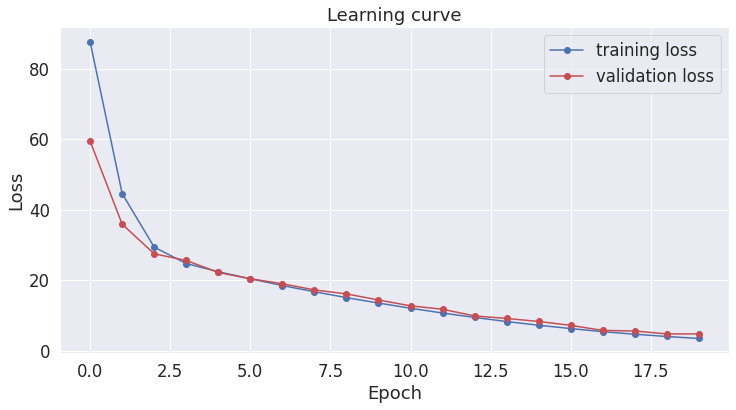

In [ ]:
history_dict = history_lstm.history

precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_lstm.evaluate(X_test, multi_label_test)
print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_lstm.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_lstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_lstm)
accuracy = accuracy_score(true_bools, pred_bools_lstm)
print(accuracy)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 11ms/step - loss: 3.4754 - precision: 0.7240 - recall: 0.6746
Test Precision: 0.724
Test Recall: 0.675
Test Average Precision Score: 0
Subset accuracy: 0.048
Hamming loss: 0.354
0.04770017035775128
Classification Report
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       165
           1       0.00      0.00      0.00        40
           2       0.72      1.00      0.84       425

   micro avg       0.50      0.94      0.65       630
   macro avg       0.34      0.67      0.43       630
weighted avg       0.56      0.94      0.68       630
 samples avg       0.50      0.94      0.65       630



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BiLSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5)))(text_embed)
textLayers = Dropout(0.25)(textLayers)
output = Dense(3, activation = 'softmax', name = 'output')(textLayers)

model_bilstm = Model(inputs = text, outputs = output)
model_bilstm.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics = [Precision(), Recall()])

history_bilstm = model_bilstm.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
41/41 [==============================] - 13s 188ms/step - loss: 208.7281 - precision_1: 0.5112 - recall_1: 0.1849 - val_loss: 116.2513 - val_precision_1: 0.2606 - val_recall_1: 0.1766
Epoch 2/20
41/41 [==============================] - 7s 165ms/step - loss: 99.2082 - precision_1: 0.5136 - recall_1: 0.2138 - val_loss: 67.8985 - val_precision_1: 0.2683 - val_recall_1: 0.1838
Epoch 3/20
41/41 [==============================] - 7s 160ms/step - loss: 61.1500 - precision_1: 0.5129 - recall_1: 0.2145 - val_loss: 52.9552 - val_precision_1: 0.2683 - val_recall_1: 0.1838
Epoch 4/20
41/41 [==============================] - 7s 159ms/step - loss: 49.4181 - precision_1: 0.5019 - recall_1: 0.2675 - val_loss: 47.2991 - val_precision_1: 0.2683 - val_recall_1: 0.1838
Epoch 5/20
41/41 [==============================] - 7s 163ms/step - loss: 44.4586 - precision_1: 0.5264 - recall_1: 0.2977 - val_loss: 42.5930 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 6/20
41/41 [===========

###Evaluation

#### Graphs

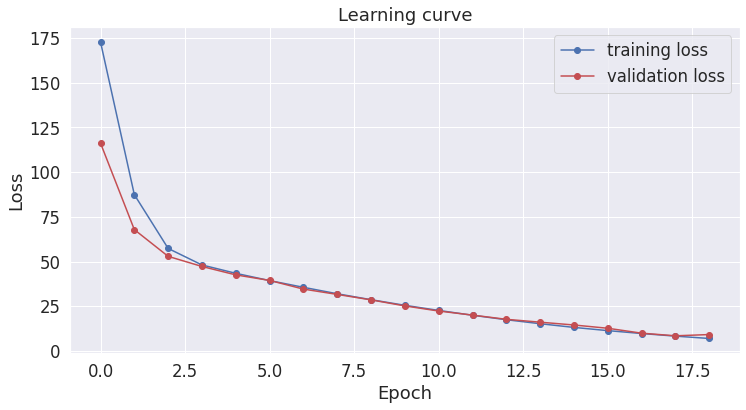

In [ ]:
history_dict = history_bilstm.history

precision = history_dict['precision_1']
val_precision = history_dict['val_precision_1']
recall = history_dict['recall_1']
val_recall = history_dict['val_recall_1']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_bilstm.evaluate(X_test, multi_label_test)

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_bilstm.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_bilstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_bilstm)
accuracy = accuracy_score(true_bools, pred_bools_bilstm)
print(accuracy)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 16ms/step - loss: 7.4714 - precision_1: 0.2931 - recall_1: 0.0540
Test Precision: 0.293
Test Recall: 0.054
Test Average Precision Score: 0
Subset accuracy: 0.048
Hamming loss: 0.354
0.04770017035775128
Classification Report
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       165
           1       0.00      0.00      0.00        40
           2       0.72      1.00      0.84       425

   micro avg       0.50      0.94      0.65       630
   macro avg       0.34      0.67      0.43       630
weighted avg       0.56      0.94      0.68       630
 samples avg       0.50      0.94      0.65       630



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(output_dim=100, input_dim=len(word_index)+1, input_length = max_text,
                       weights = [embedding_matrix], trainable = True))

cnn_model.add(Conv1D(filters = 250,
                     kernel_size = 3, 
                     padding = 'valid'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))

cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", 
              metrics=[Precision(), Recall()]) 

history_cnn = cnn_model.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
41/41 [==============================] - 2s 26ms/step - loss: 3.7823 - precision_2: 0.5104 - recall_2: 0.4016 - val_loss: 56.3070 - val_precision_2: 0.1916 - val_recall_2: 0.1313
Epoch 2/20
41/41 [==============================] - 1s 17ms/step - loss: 40.2983 - precision_2: 0.4740 - recall_2: 0.4126 - val_loss: 426.7269 - val_precision_2: 0.2683 - val_recall_2: 0.1838


### Evaluation

#### Graphs

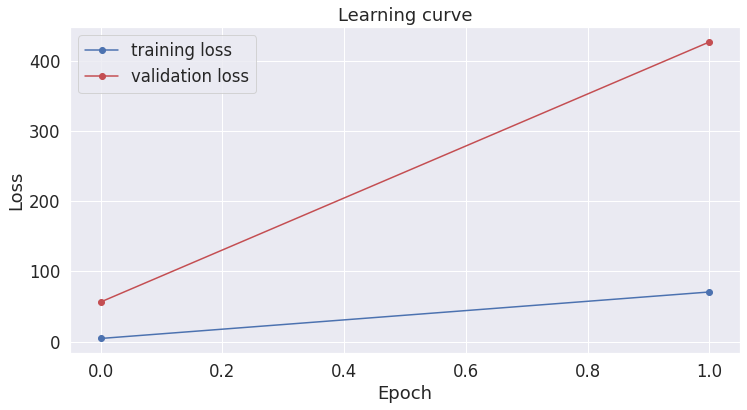

In [ ]:
history_dict = history_cnn.history

precision = history_dict['precision_2']
val_precision = history_dict['val_precision_2']
recall = history_dict['recall_2']
val_recall = history_dict['val_recall_2']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

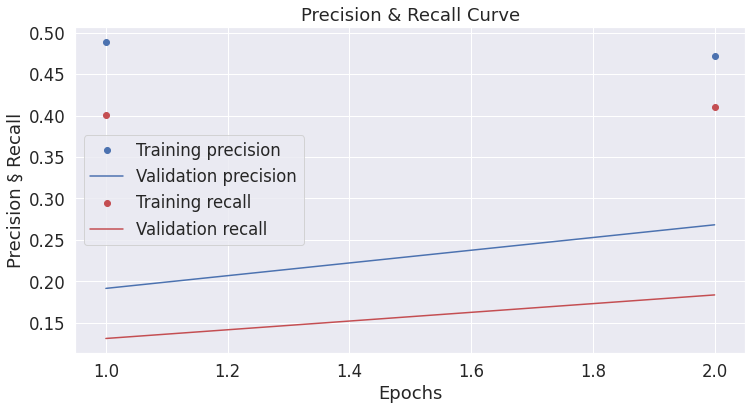

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = cnn_model.evaluate(X_test, multi_label_test)
f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test F1-Score: {}".format(round(f1_score,3)))
print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = cnn_model.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_cnn = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_cnn)
accuracy = accuracy_score(true_bools, pred_bools_cnn)
print(accuracy)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 4ms/step - loss: 88.9045 - precision_2: 0.7240 - recall_2: 0.6746
Test F1-Score: 0.698
Test Precision: 0.724
Test Recall: 0.675
Test Average Precision Score: 0
Subset accuracy: 0.663
Hamming loss: 0.208
0.6626916524701874
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.00      0.00      0.00        40
           2       0.72      1.00      0.84       425

   micro avg       0.72      0.67      0.70       630
   macro avg       0.24      0.33      0.28       630
weighted avg       0.49      0.67      0.57       630
 samples avg       0.72      0.69      0.70       630



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ELMO

## Model

In [ ]:
# In order to download the pretrained ELMO layer from the hub, lower the Tensorflow version
# Since this version of tensorflow requires to restart the runtime, the data processing part until 
# "Data Processing for Neural Networks" is needed to be run again.
!pip install tensorflow==1.15.0
!pip install tensorflow_hub

     |████████████████████████████████| 412.3MB 33kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 3.8MB 56.0MB/s 
     |████████████████████████████████| 512kB 58.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=34964483468c523182f88ffe734c973a66df46935505b9dd7fce8514789bc485
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [ ]:
# Adjust the data into a proper format 
xtrain = np.array(train_Text)
ytrain = multi_label
xtest = np.array(test_Text)
ytest = multi_label_test

# Download the pretrained ELMO layer from Tensorflow hub
embed = hub.Module("https://tfhub.dev/google/elmo/2")
def ELMoEmbedding(x):
    return embed(tf.reshape(tf.cast(x, tf.string), [-1]), signature="default", as_dict=True)['default']

# Model Metrics
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# ELMO Model
def build_model(): 
    input_comment = Input(shape=(1,), dtype="string", name='input_comment')
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_comment)
    dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(embedding)
    pred = Dense(3, activation='sigmoid')(dense)
    model = Model(inputs=[input_comment], outputs=pred)
    model.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', recall_m,
                                                                                               precision_m, f1_m]) 
    return model
model_elmo = build_model()

# Fit the train data & Take predictions
earlystopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history_elmo = model_elmo.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=4, batch_size=32)
    results = model_elmo.evaluate(xtest, ytest)
    pred_labels = model_elmo.predict(xtest)
    multi_preds = pred_labels >= 0.10
    multi_preds = multi_preds.astype(int)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2864 samples, validate on 587 samples
Epoch 1/4
2864/2864 [==============================] - 109s 38ms/sample - loss: 1.6168 - acc: 0.4756 - recall_m: 0.7311 - precision_m: 0.4972 - f1_m: 0.5854 - val_loss: 1.3886 - val_acc: 0.5571 - val_recall_m: 0.5761 - val_precision_m: 0.5818 - val_f1_m: 0.5776
Epoch 2/4
2864/2864 [==============================] - 109s 38ms/sample - loss: 1.5030 - acc: 0.5499 - recall_m: 0.2225 - precision_m: 0.7074 - f1_m: 0.3067 - val_loss: 1.4050 - val_acc: 0.4940 - val_recall_m: 0.0352 - val_precision_m: 0.4687 - val_f1_m: 0.0639
Epoch 3/4
2864/2864 [==============================] - 103s 36ms/sample - loss: 1.4184 - acc: 0.6086 - recall_m: 0.0258 - precision_m: 0.4493 - f1_m: 0.0478 - val_loss: 1.3513 - val_acc: 0.5537 - val_recall_m: 0.0123 - val_precision_m: 0.2105 - val_f1_m: 0.0224
Epoch 4/4
587/587 [==============================] - 16s 28ms/sample - loss: 1.4000 - acc: 0.5503 - recall_m: 0.0015 - precision_m: 0.0526 - f1_m: 0.0030


## Evaluation

### Graphs

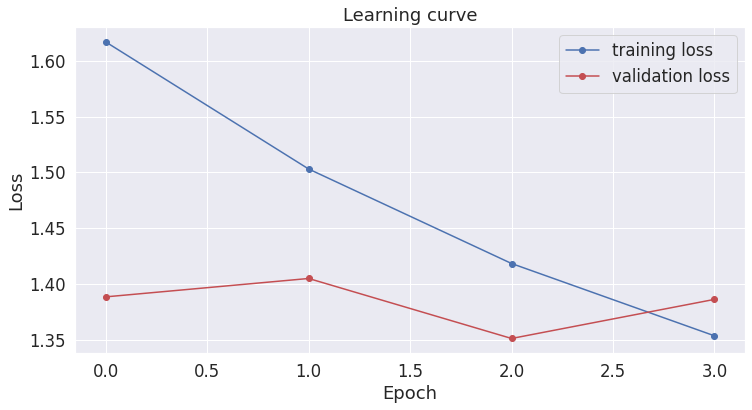

In [ ]:
history_dict = history_elmo.history

precision = history_dict['precision_m']
val_precision = history_dict['val_precision_m']
recall = history_dict['recall_m']
val_recall = history_dict['val_recall_m']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

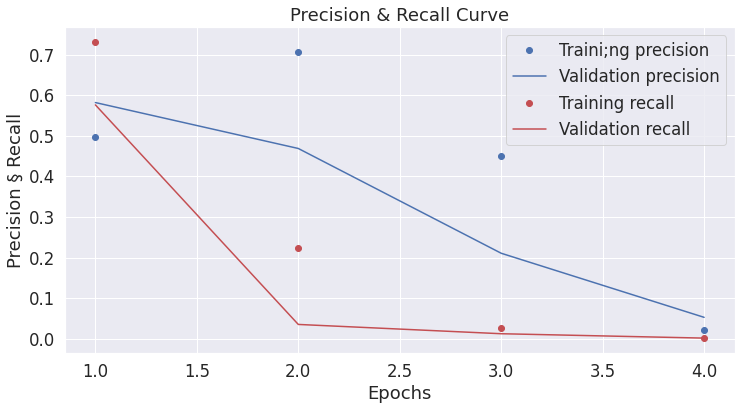

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Traini;ng precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
print("Test Accuracy: {}".format(round(results[1],3)))
print("Test Recall: {}".format(round(results[2], 3)))
print("Test Precision: {}".format(round(results[3], 3)))
print("Test F1 Score: {}".format(round(results[4], 3)))

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_elmo = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_elmo)
accuracy = accuracy_score(true_bools, pred_bools_elmo)
print(accuracy)
print('Classification Report')
print(clf_report)

Test Accuracy: 0.550000011920929
Test Recall: 0.0020000000949949026
Test Precision: 0.05299999937415123
Test F1 Score: 0.003000000026077032
Test Average Precision Score: 0
Subset accuracy: 0.351
Hamming loss: 0.323
0.35093696763202725
Classification Report
              precision    recall  f1-score   support

           0       0.26      0.41      0.32       165
           1       0.16      0.20      0.18        40
           2       0.73      0.80      0.77       425

   micro avg       0.54      0.66      0.60       630
   macro avg       0.39      0.47      0.42       630
weighted avg       0.57      0.66      0.61       630
 samples avg       0.53      0.67      0.57       630



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT


## Bert Tokenization

In [15]:
# add special tokens for BERT to work properly
sentences = ["[CLS] " + sent + " [SEP]" for sent in train_Text.astype(str)]
sentences_test = ["[CLS] " + sent + " [SEP]" for sent in test_Text.astype(str)]

sentences[0], sentences_test[0]

('[CLS] Judging from previous posts this used to be a good place, but not any longer. [SEP]',
 '[CLS] Yum! [SEP]')

For the tokenization, pre-trained Bert-Base-Uncased dictionary is used. They constructed it with WordPiece embeddings with a 30,000 token vocabulary. 

In [16]:
# Tokenize with BERT tokenizer both train and test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]

tokenized_texts[0], tokenized_texts_test[0]

(['[CLS]',
  'judging',
  'from',
  'previous',
  'posts',
  'this',
  'used',
  'to',
  'be',
  'a',
  'good',
  'place',
  ',',
  'but',
  'not',
  'any',
  'longer',
  '.',
  '[SEP]'],
 ['[CLS]', 'yu', '##m', '!', '[SEP]'])

## Input Preparation

For the BERT model to work, we need three inputs. 
- Input IDs: shows the ID number of each token with padding. The ID numbers are restored from the BERT vocabulary dictionary.
- Mask IDs: indicates which elements in the sequence are tokens and which are padding elements.
- Segment IDs: distinguishes different sentences, 0 for one-sentence sequence, 1 if there are two sentences.

The functions below are extracted from: https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [17]:
def get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def get_masks(tokens, max_seq_length):
    if len(tokens) > max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [18]:
# find the longest sequence for the padding
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)
    
longestSeq_train = find_max_list(tokenized_texts)
longestSeq_test = find_max_list(tokenized_texts_test)
max_seq_length = max(longestSeq_train, longestSeq_test)
print(max_seq_length)

93


In [19]:
# Find input_ids, mask_ids and segment_ids of the train and test data.
max_seq_length = max_seq_length
input_ids = []
mask_ids = [] 
segments_ids = []
for i in range(len(tokenized_texts)):
    input_ids.append(get_ids(tokenized_texts[i], tokenizer, max_seq_length))
    mask_ids.append(get_masks(tokenized_texts[i], max_seq_length))
    segments_ids.append(get_segments(tokenized_texts[i], max_seq_length))
    
input_ids_test = []
mask_ids_test = [] 
segments_ids_test = [] 
for i in range(len(tokenized_texts_test)):
    input_ids_test.append(get_ids(tokenized_texts_test[i], tokenizer, max_seq_length))
    mask_ids_test.append(get_masks(tokenized_texts_test[i], max_seq_length))
    segments_ids_test.append(get_segments(tokenized_texts_test[i], max_seq_length))
    
# For the model, I converted the lists to tensors.
input_ids = tf.convert_to_tensor(input_ids, dtype = tf.int32)
mask_ids = tf.convert_to_tensor(mask_ids, dtype = tf.int32)
segments_ids = tf.convert_to_tensor(segments_ids, dtype = tf.int32)

input_ids_test = tf.convert_to_tensor(input_ids_test, dtype = tf.int32)
mask_ids_test = tf.convert_to_tensor(mask_ids_test, dtype = tf.int32)
segments_ids_test = tf.convert_to_tensor(segments_ids_test, dtype = tf.int32)

## Model

I used the uncased BERT model with 12 hidden layers and 110M parameters, trained on Wikipedia and Book-Corpus data and hosted by Google on TensorFlow Hub. 

In [ ]:
random.seed(123)
# Three Inputs of the Bert Model
InputIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "InputIDs")
MaskIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "MaskIDs")
SegmentIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "SegmentIDs")

# Import the pre-trained uncased Bert model
bertLayer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

# Since it is a classisfication problem, the pooled output is needed.
pooled_output, sequence_output = bertLayer([InputIDLayer, MaskIDLayer, SegmentIDLayer])
pooled_output = Dropout(0.5)(pooled_output)
output = Dense(units = 768, activation = "tanh")(pooled_output)
output = Dropout(0.5)(output)
output = Dense(units = 3, activation = "softmax")(output)

model = Model(inputs=[InputIDLayer, MaskIDLayer, SegmentIDLayer], outputs = output)

# Model Compilation
learning_rate = 2e-5
number_of_epochs = 10
optimizer = Adam(learning_rate = learning_rate, epsilon = 1e-08)
loss = CategoricalCrossentropy(from_logits = False)
metrics = [Precision(), Recall(),
          FalseNegatives(), FalsePositives()]

model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = metrics)

# Model Training & Fine-Tuning on train data
earlyStopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)
checkpoint_path = 'training/cp.ckpt'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_best_only = False,
                                                 save_weights_only = True,
                                                 verbose = 1)

bert_history = model.fit([input_ids, mask_ids, segments_ids], [multi_label],
                         epochs = number_of_epochs, 
                         batch_size = 64,
                         validation_split = 0.1,
                         #callbacks = [earlyStopping, cp_callback]
                         )

## Performance Graphs

### Loss Graph

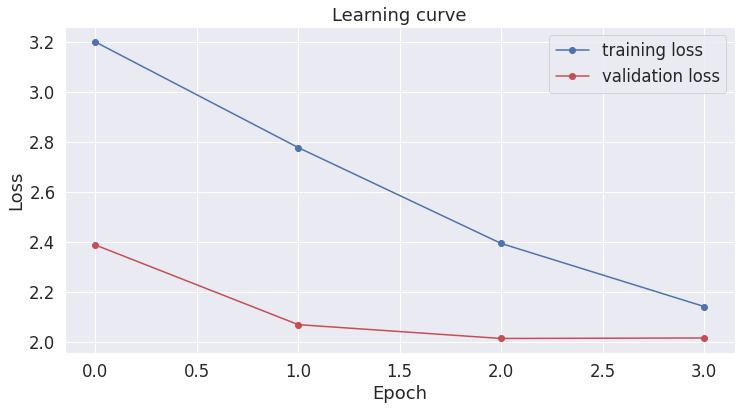

In [ ]:
history_dict = bert_history.history

precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Precision & Recall Graph

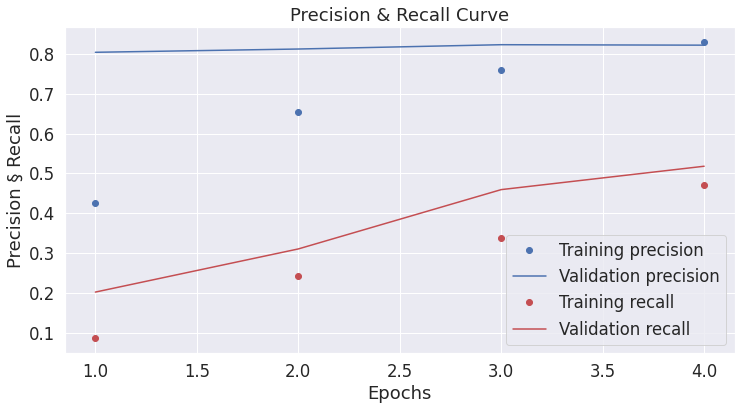

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

## Model Evaluation

### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss

https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit/234354



In [ ]:
# Model Evaluation - Loss, Precision, Recall, PrecisionAtRecall, RecallAtPrecision, FalseNegatives, FalsePositives
results = model.evaluate([input_ids_test, mask_ids_test, segments_ids_test], multi_label_test)
f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test F1-Score: {}".format(round(f1_score,3)))
print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model.predict([input_ids_test, mask_ids_test, segments_ids_test])

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))

# Hamming Score
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

if __name__ == "__main__":
    print('Hamming score: {0}'.format(round(hamming_score(multi_label_test, multi_preds), 3))) # 0.375 (= (0.5+1+0+0)/4)

    # Subset accuracy
    # 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
    print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))

    # Hamming loss (smaller is better)
    print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

19/19 [==============================] - 7s 351ms/step - loss: 1.9526 - precision: 0.8211 - recall: 0.5559 - false_negatives: 330.0000 - false_positives: 90.0000
Test F1-Score: 0.663
Test Precision: 0.821
Test Recall: 0.556
Test Average Precision Score: 0.0
Hamming score: 0.636
Subset accuracy: 0.455
Hamming loss: 0.084


## Label Based Evaluation

### Classification Report

In [ ]:
# Predictions
pred_labels = model.predict([input_ids_test, mask_ids_test, segments_ids_test])

# Calculate Accuracy
threshold = 0.10
pred_bools = [pl>threshold for pl in pred_labels]
true_bools = [tl==1 for tl in multi_label_test]

clf_report = classification_report(true_bools, pred_bools, #target_names=test_label_cols
                                   )
print(clf_report)

              precision    recall  f1-score   support

           0       0.32      0.88      0.47        57
           1       0.25      0.33      0.29         3
           2       0.33      0.10      0.15        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.65      0.99      0.78       226
           6       0.36      0.17      0.23        48
           7       0.00      0.00      0.00        13
           8       0.59      0.89      0.71       142
           9       0.43      0.09      0.15        33
          10       0.25      0.10      0.14        21
          11       0.74      0.87      0.80       145

   micro avg       0.58      0.73      0.65       743
   macro avg       0.33      0.37      0.31       743
weighted avg       0.54      0.73      0.60       743
 samples avg       0.70      0.78      0.70       743



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrices

In [ ]:
# Confusion Matrices
# Setting the threshold as 0.10
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

y_true = multi_label_test
y_pred = pred_clean

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]

# Confusion Matrices
conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)
    precision = matrix[0][0] / (matrix[0][0] + matrix[1][0])
    print("Precision: {}".format(round(precision, 2)))
    recall = matrix[0][0] / (matrix[0][0] + matrix[0][1])
    print("Recall: {}".format(round(recall, 2)))
    f1_score =  2 * (precision * recall)/(precision + recall)
    print("F1 Score: {}".format(round(f1_score, 2)))

Confusion matrix for label 0:
[[424 106]
 [  7  50]]
Precision: 0.98
Recall: 0.8
F1 Score: 0.88
Confusion matrix for label 1:
[[581   3]
 [  2   1]]
Precision: 1.0
Recall: 0.99
F1 Score: 1.0
Confusion matrix for label 2:
[[562   4]
 [ 19   2]]
Precision: 0.97
Recall: 0.99
F1 Score: 0.98
Confusion matrix for label 3:
[[574   1]
 [ 12   0]]
Precision: 0.98
Recall: 1.0
F1 Score: 0.99
Confusion matrix for label 4:
[[565   0]
 [ 22   0]]
Precision: 0.96
Recall: 1.0
F1 Score: 0.98
Confusion matrix for label 5:
[[240 121]
 [  3 223]]
Precision: 0.99
Recall: 0.66
F1 Score: 0.79
Confusion matrix for label 6:
[[525  14]
 [ 40   8]]
Precision: 0.93
Recall: 0.97
F1 Score: 0.95
Confusion matrix for label 7:
[[574   0]
 [ 13   0]]
Precision: 0.98
Recall: 1.0
F1 Score: 0.99
Confusion matrix for label 8:
[[358  87]
 [ 16 126]]
Precision: 0.96
Recall: 0.8
F1 Score: 0.87
Confusion matrix for label 9:
[[550   4]
 [ 30   3]]
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Confusion matrix for label 10:
[[560 

- 0: Ambience#General
- 1: Drinks#Prices
- 2: Drinks#Quality
- 3: Drinks#Style_Options
- 4: Food#Prices
- 5: Food#Quality
- 6: Food#Style_Options
- 7: Location#General
- 8: Restaurant#General
- 9: Restaurant#Miscelleanous
- 10: Restaurant#Prices
- 11: Service#General

